# ASymCat: Comprehensive Examples with Mathematical Analysis

This notebook demonstrates ASymCat's capabilities with real datasets, mathematical explanations, and comprehensive visualizations.

## Table of Contents
1. [Mathematical Foundations](#Mathematical-Foundations)
2. [Species Co-occurrence: Galápagos Finches](#Species-Co-occurrence)
3. [Linguistic Analysis: CMU Pronunciation Dictionary](#Linguistic-Analysis)
4. [Classification Analysis: Mushroom Edibility](#Classification-Analysis)
5. [Comparative Analysis: Pokémon Type Relationships](#Comparative-Analysis)
6. [Advanced: Smoothing Effects](#Advanced-Smoothing)
7. [Interpretation Guidelines](#Interpretation-Guidelines)

In [1]:
# Import libraries
import asymcat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("ASymCat version:", asymcat.__version__ if hasattr(asymcat, '__version__') else "Latest")

ASymCat version: 0.3.1


## Mathematical Foundations

### Asymmetric vs Symmetric Association

**Symmetric measures** treat relationships as bidirectional:
- χ² (Chi-square): Tests independence
- PMI (Pointwise Mutual Information): Measures information overlap
- Jaccard Index: Set overlap similarity

**Asymmetric measures** capture directional dependencies:
- MLE: Conditional probability P(Y|X) ≠ P(X|Y)
- Theil's U: Proportional uncertainty reduction U(Y|X) ≠ U(X|Y)
- Lambda: Prediction error reduction λ(Y|X) ≠ λ(X|Y)

### Simple Mathematical Example

Mathematical Example: Perfect Asymmetry
Data: A→{c,c,d}, B→{g,g,f}

Pair ('A', 'c'):
  MLE: P(c|A) = 1.000, P(A|c) = 0.667
  PMI: 0.693 (symmetric)
  Theil U: U(c|A) = 0.000, U(A|c) = 1.000

Pair ('B', 'g'):
  MLE: P(g|B) = 1.000, P(B|g) = 0.667
  PMI: 0.693 (symmetric)
  Theil U: U(g|B) = 0.000, U(B|g) = 1.000



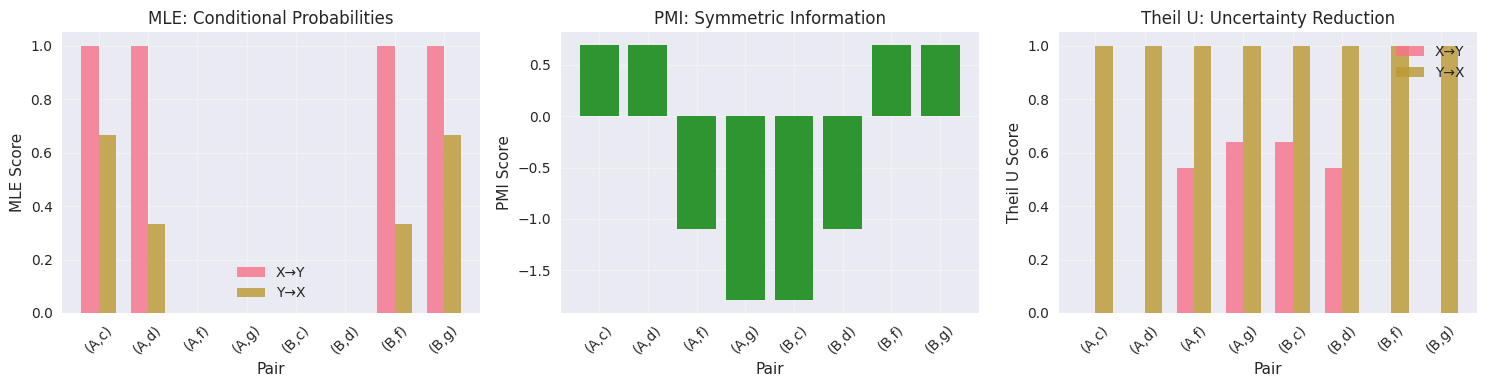

In [2]:
# Create a simple asymmetric dataset
simple_data = [
    ('A', 'c'), ('A', 'c'), ('A', 'd'),  # A can lead to c or d
    ('B', 'g'), ('B', 'g'), ('B', 'f'),  # B can lead to g or f
]

# CatScorer expects (x, y) tuples directly
scorer = asymcat.scorer.CatScorer(simple_data)

# Compute measures
mle_scores = scorer.mle()
pmi_scores = scorer.pmi()
theil_scores = scorer.theil_u()

print("Mathematical Example: Perfect Asymmetry")
print("=====================================")
print("Data: A→{c,c,d}, B→{g,g,f}")
print()

for pair in [('A', 'c'), ('B', 'g')]:
    if pair in mle_scores:
        xy, yx = mle_scores[pair]
        pmi_val = pmi_scores[pair][0]  # PMI is symmetric
        u_xy, u_yx = theil_scores[pair]
        
        print(f"Pair {pair}:")
        print(f"  MLE: P({pair[1]}|{pair[0]}) = {xy:.3f}, P({pair[0]}|{pair[1]}) = {yx:.3f}")
        print(f"  PMI: {pmi_val:.3f} (symmetric)")
        print(f"  Theil U: U({pair[1]}|{pair[0]}) = {u_xy:.3f}, U({pair[0]}|{pair[1]}) = {u_yx:.3f}")
        print()

# Visualize the simple example
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Extract data for plotting
pairs = list(mle_scores.keys())
mle_xy = [mle_scores[p][0] for p in pairs]
mle_yx = [mle_scores[p][1] for p in pairs]
pair_labels = [f"({p[0]},{p[1]})" for p in pairs]

# MLE comparison
x = np.arange(len(pairs))
width = 0.35
axes[0].bar(x - width/2, mle_xy, width, label='X→Y', alpha=0.8)
axes[0].bar(x + width/2, mle_yx, width, label='Y→X', alpha=0.8)
axes[0].set_xlabel('Pair')
axes[0].set_ylabel('MLE Score')
axes[0].set_title('MLE: Conditional Probabilities')
axes[0].set_xticks(x)
axes[0].set_xticklabels(pair_labels, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PMI (symmetric)
pmi_vals = [pmi_scores[p][0] for p in pairs]
axes[1].bar(x, pmi_vals, alpha=0.8, color='green')
axes[1].set_xlabel('Pair')
axes[1].set_ylabel('PMI Score')
axes[1].set_title('PMI: Symmetric Information')
axes[1].set_xticks(x)
axes[1].set_xticklabels(pair_labels, rotation=45)
axes[1].grid(True, alpha=0.3)

# Theil's U comparison
theil_xy = [theil_scores[p][0] for p in pairs]
theil_yx = [theil_scores[p][1] for p in pairs]
axes[2].bar(x - width/2, theil_xy, width, label='X→Y', alpha=0.8)
axes[2].bar(x + width/2, theil_yx, width, label='Y→X', alpha=0.8)
axes[2].set_xlabel('Pair')
axes[2].set_ylabel('Theil U Score')
axes[2].set_title('Theil U: Uncertainty Reduction')
axes[2].set_xticks(x)
axes[2].set_xticklabels(pair_labels, rotation=45)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Species Co-occurrence: Galápagos Finches

The Galápagos dataset contains presence-absence data for 13 finch species across 17 islands. This is a classic example of **species co-occurrence analysis** where we want to understand:

1. Which species **co-occur** more often than expected by chance?
2. Are there **asymmetric relationships** (species A predicts species B, but not vice versa)?
3. What are the **ecological implications** of these patterns?

Galápagos Dataset: 71383 co-occurrences
Species pairs analyzed: 71383



Data shape: (17, 13) (islands × species)
Species: ['G. magnirostris', 'G. fortis', 'G. fuliginosa', 'G. difficilis', 'G. scandens']...
Islands: ['Seymour', 'Baltra', 'Isabela', 'Fernandina', 'Santiago']...


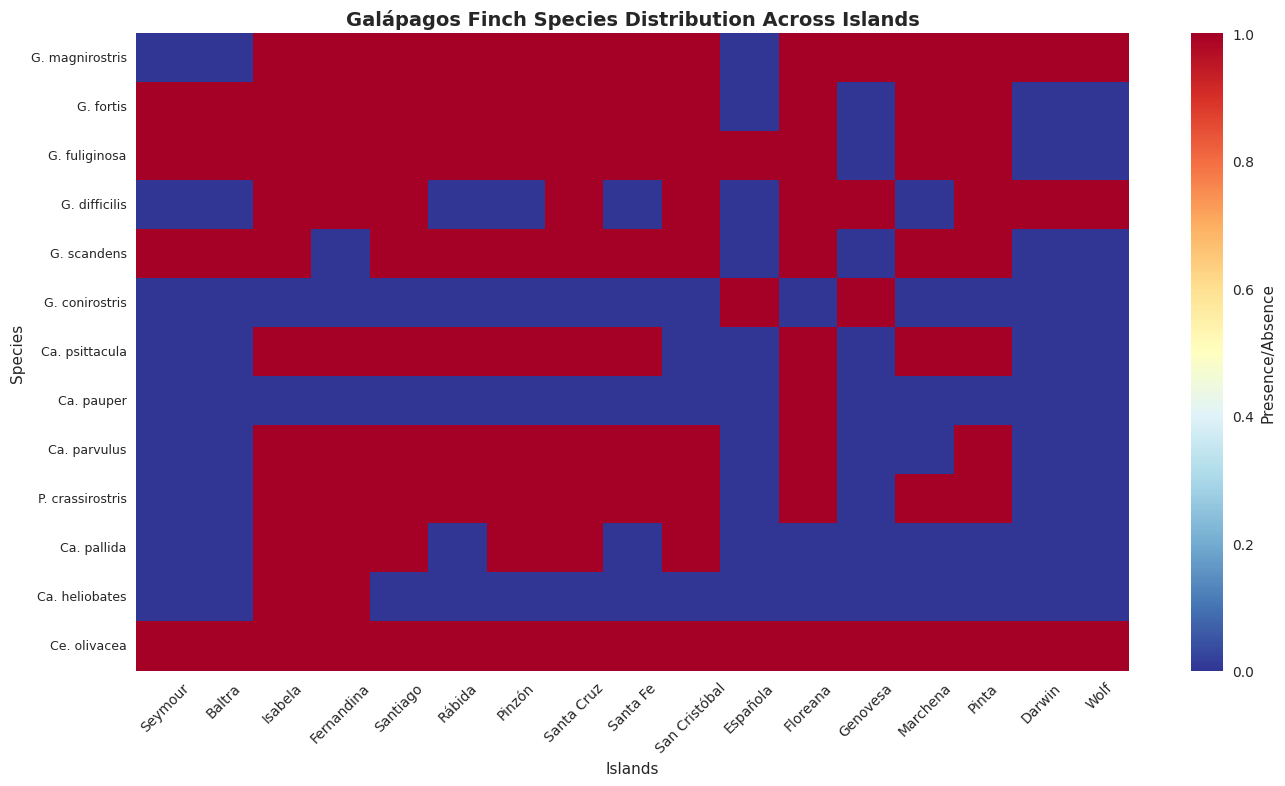

In [3]:
# Load Galápagos finch data
galapagos_data = asymcat.read_pa_matrix("../resources/galapagos.tsv")
galapagos_cooccs = asymcat.collect_cooccs(galapagos_data)

print(f"Galápagos Dataset: {len(galapagos_cooccs)} co-occurrences")
print(f"Species pairs analyzed: {len(galapagos_cooccs)}")

# Create scorer with Laplace smoothing for better estimates with sparse data
galapagos_scorer = asymcat.scorer.CatScorer(galapagos_cooccs, 
                                          smoothing_method='laplace')

# Compute multiple measures
measures = {
    'MLE': galapagos_scorer.mle(),
    'PMI': galapagos_scorer.pmi(),
    'Jaccard': galapagos_scorer.jaccard_index(),
    'Theil_U': galapagos_scorer.theil_u()
}

# Display raw data structure
df = pd.read_csv("../resources/galapagos.tsv", sep='\t', index_col=0)
print(f"\nData shape: {df.shape} (islands × species)")
print(f"Species: {list(df.columns)[:5]}...")  # Show first 5 species
print(f"Islands: {list(df.index)[:5]}...")   # Show first 5 islands

# Show presence/absence matrix
plt.figure(figsize=(14, 8))
sns.heatmap(df.T, cmap='RdYlBu_r', cbar_kws={'label': 'Presence/Absence'}, 
            xticklabels=True, yticklabels=True)
plt.title('Galápagos Finch Species Distribution Across Islands', fontsize=14, fontweight='bold')
plt.xlabel('Islands')
plt.ylabel('Species')
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

In [4]:
# Analyze strongest associations
def analyze_top_associations(scores, measure_name, n_top=10):
    """Analyze top associations for a given measure."""
    print(f"\n=== {measure_name} Analysis ===")
    
    # Get all scores and sort by strength
    all_scores = []
    for pair, (xy, yx) in scores.items():
        all_scores.append((pair, xy, yx, max(xy, yx)))
    
    # Sort by maximum score in either direction
    all_scores.sort(key=lambda x: x[3], reverse=True)
    
    print(f"Top {n_top} associations:")
    for i, (pair, xy, yx, max_score) in enumerate(all_scores[:n_top]):
        direction = "→" if xy > yx else "←"
        print(f"{i+1:2d}. {pair[0]} {direction} {pair[1]}: "
              f"{xy:.3f} (X→Y), {yx:.3f} (Y→X)")
    
    return all_scores[:n_top]

# Analyze each measure
top_mle = analyze_top_associations(measures['MLE'], 'MLE (Conditional Probability)')
top_jaccard = analyze_top_associations(measures['Jaccard'], 'Jaccard Index')
top_theil = analyze_top_associations(measures['Theil_U'], 'Theil Uncertainty Coefficient')


=== MLE (Conditional Probability) Analysis ===
Top 10 associations:
 1. m ← s: 0.006 (X→Y), 0.226 (Y→X)
 2. n ← s: 0.023 (X→Y), 0.213 (Y→X)
 3. a → v: 0.211 (X→Y), 0.010 (Y→X)
 4. g ← s: 0.015 (X→Y), 0.204 (Y→X)
 5. a → C: 0.203 (X→Y), 0.014 (Y→X)
 6. a → p: 0.201 (X→Y), 0.007 (Y→X)
 7. G ← s: 0.037 (X→Y), 0.180 (Y→X)
 8. a → l: 0.171 (X→Y), 0.032 (Y→X)
 9. f ← s: 0.033 (X→Y), 0.164 (Y→X)
10. a → u: 0.162 (X→Y), 0.019 (Y→X)

=== Jaccard Index Analysis ===
Top 10 associations:
 1. a ← i: 0.070 (X→Y), 0.070 (Y→X)
 2. a ← s: 0.069 (X→Y), 0.069 (Y→X)
 3. i ← s: 0.066 (X→Y), 0.066 (Y→X)
 4.   ← s: 0.055 (X→Y), 0.055 (Y→X)
 5. . ← s: 0.055 (X→Y), 0.055 (Y→X)
 6. i ← i: 0.054 (X→Y), 0.054 (Y→X)
 7. a ← a: 0.054 (X→Y), 0.054 (Y→X)
 8. a ←  : 0.053 (X→Y), 0.053 (Y→X)
 9. a ← .: 0.053 (X→Y), 0.053 (Y→X)
10. s ← s: 0.051 (X→Y), 0.051 (Y→X)

=== Theil Uncertainty Coefficient Analysis ===
Top 10 associations:
 1. m → i: 0.610 (X→Y), 0.044 (Y→X)
 2. m →  : 0.586 (X→Y), 0.060 (Y→X)
 3. m → .: 0.586 

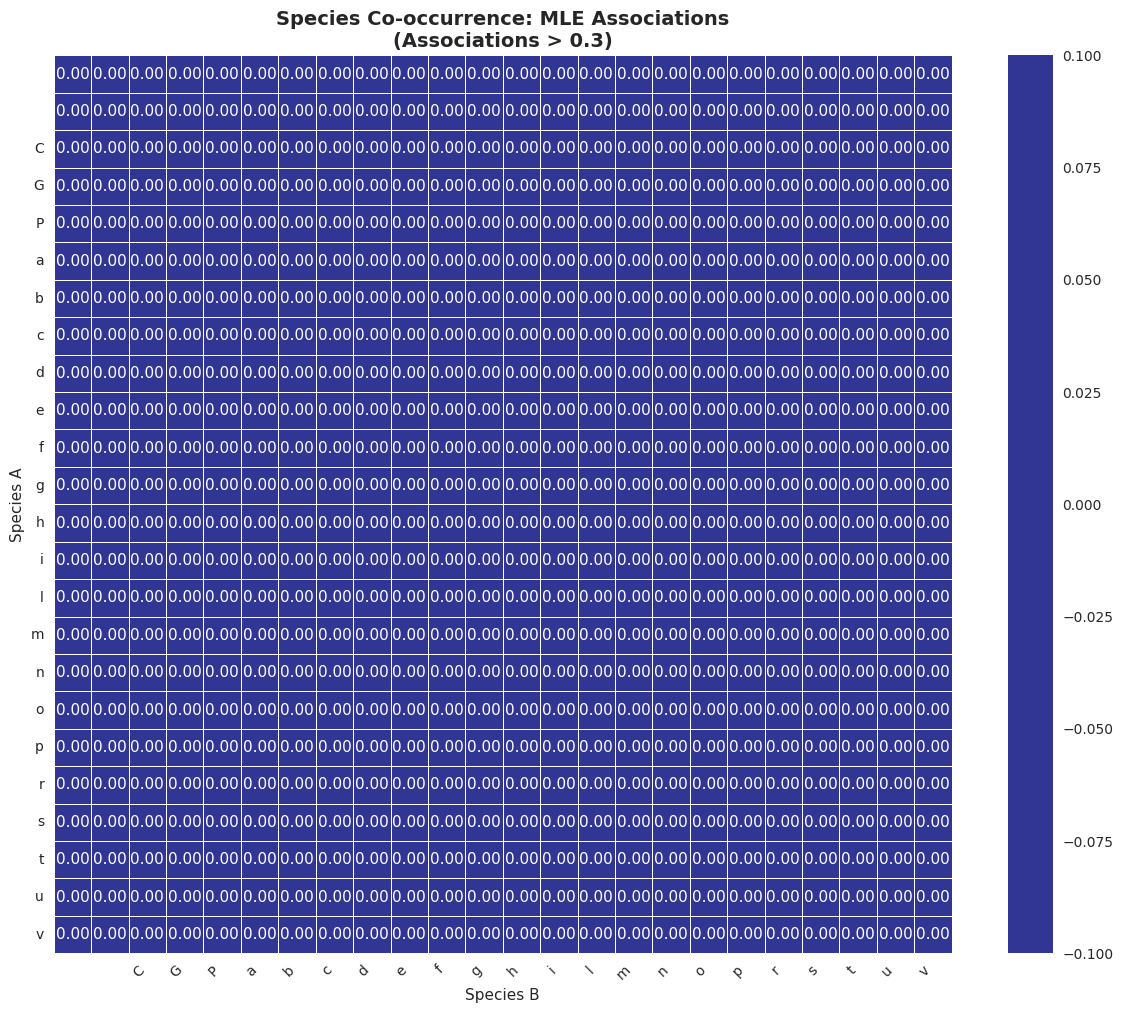

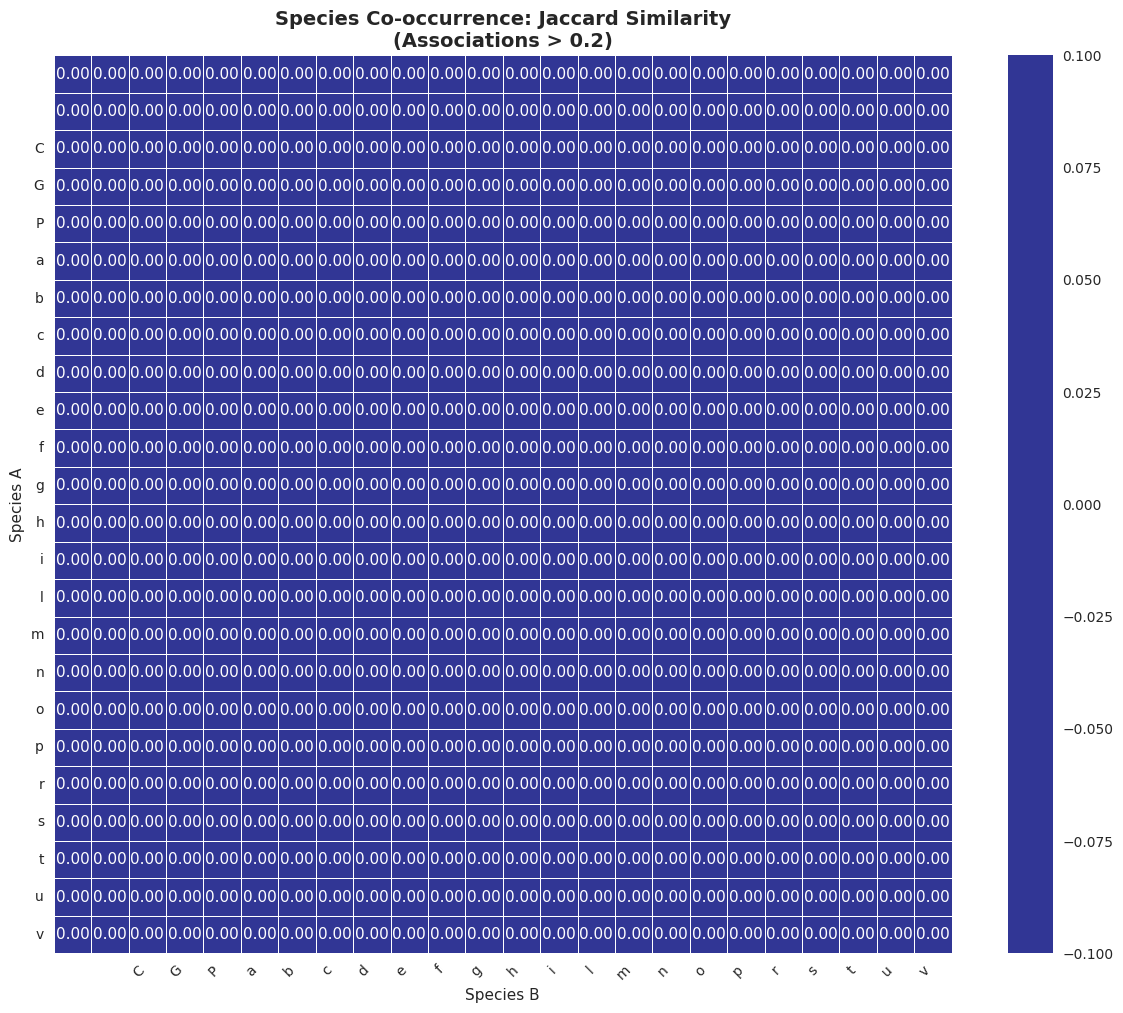

In [5]:
# Visualize association networks
def create_association_heatmap(scores, title, threshold=0.5):
    """Create heatmap of associations above threshold."""
    
    # Get all unique species
    all_species = set()
    for pair in scores.keys():
        all_species.update(pair)
    species_list = sorted(all_species)
    
    # Create matrices
    n = len(species_list)
    xy_matrix = np.zeros((n, n))
    yx_matrix = np.zeros((n, n))
    
    species_to_idx = {sp: i for i, sp in enumerate(species_list)}
    
    for (sp1, sp2), (xy, yx) in scores.items():
        i, j = species_to_idx[sp1], species_to_idx[sp2]
        xy_matrix[i, j] = xy
        yx_matrix[j, i] = yx  # Note the transpose for Y→X
    
    # Create asymmetric matrix (show strongest direction)
    asym_matrix = np.maximum(xy_matrix, yx_matrix.T)
    
    # Mask weak associations
    asym_matrix = np.where(asym_matrix > threshold, asym_matrix, 0)
    
    # Plot
    plt.figure(figsize=(12, 10))
    
    # Shorten species names for display
    short_names = [name.split('.')[0] if '.' in name else name[:10] 
                   for name in species_list]
    
    sns.heatmap(asym_matrix, 
                xticklabels=short_names,
                yticklabels=short_names,
                annot=True, fmt='.2f', 
                cmap='RdYlBu_r', center=threshold,
                square=True,
                linewidths=0.5)
    
    plt.title(f'{title}\n(Associations > {threshold})', fontsize=14, fontweight='bold')
    plt.xlabel('Species B')
    plt.ylabel('Species A')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return asym_matrix, species_list

# Create heatmaps for different measures
mle_matrix, species = create_association_heatmap(measures['MLE'], 
                                                'Species Co-occurrence: MLE Associations', 
                                                threshold=0.3)

jaccard_matrix, _ = create_association_heatmap(measures['Jaccard'], 
                                              'Species Co-occurrence: Jaccard Similarity', 
                                              threshold=0.2)

### Ecological Interpretation

The Galápagos analysis reveals several important ecological patterns:

1. **Habitat Specialization**: Some species co-occur frequently, suggesting shared habitat preferences
2. **Island Biogeography**: Larger islands (like Isabela) support more species diversity
3. **Competitive Exclusion**: Some species pairs never co-occur, possibly due to competition
4. **Asymmetric Dependencies**: Species A may predict species B's presence better than vice versa

## Linguistic Analysis: CMU Pronunciation Dictionary

Analyzing orthography-to-phonetics mappings reveals **systematic patterns** in English pronunciation:

- **Grapheme-Phoneme Correspondence**: How letters map to sounds
- **Phonotactic Patterns**: Which sound combinations are common
- **Asymmetric Relationships**: Orthography may predict phonetics better than vice versa

In [6]:
# Load CMU dictionary data
cmu_data = asymcat.read_sequences("../resources/cmudict.sample1000.tsv")
cmu_cooccs = asymcat.collect_cooccs(cmu_data)

print(f"CMU Dictionary Sample: {len(cmu_data)} words")
print(f"Co-occurrences: {len(cmu_cooccs)} orthography-phoneme pairs")

# Show sample data
print("\nSample orthography-phoneme alignments:")
for i in range(5):
    ortho, phon = cmu_data[i]
    print(f"'{' '.join(ortho)}' → /{' '.join(phon)}/")

# Create scorer with different smoothing methods
cmu_scorer_mle = asymcat.scorer.CatScorer(cmu_cooccs, smoothing_method='mle')
cmu_scorer_smooth = asymcat.scorer.CatScorer(cmu_cooccs, smoothing_method='laplace')

# Compute measures
cmu_mle = cmu_scorer_mle.mle()
cmu_mle_smooth = cmu_scorer_smooth.mle()
cmu_pmi = cmu_scorer_mle.pmi()
cmu_pmi_smooth = cmu_scorer_smooth.pmi_smoothed()

print(f"\nMeasures computed for {len(cmu_mle)} orthography-phoneme pairs")

CMU Dictionary Sample: 1000 words
Co-occurrences: 51873 orthography-phoneme pairs

Sample orthography-phoneme alignments:
'A B A C K' → /ʌ b æ k/
'A B B R E V I A T I O N' → /ʌ b ɹ i v i eɪ ʃ ʌ n/
'A B R U Z Z O' → /ɑ b ɹ u z oʊ/
'A C C E S S I N G' → /æ k s ɛ s ɪ ŋ/
'A C E R B I C' → /ʌ s ɛ ɹ b ɪ k/



Measures computed for 1014 orthography-phoneme pairs


In [7]:
# Analyze orthography-phoneme correspondences
def analyze_grapheme_phoneme(scores, title, n_top=15):
    """Analyze strongest grapheme-phoneme correspondences."""
    print(f"\n=== {title} ===")
    
    # Separate orthography→phoneme and phoneme→orthography
    ortho_to_phon = []
    phon_to_ortho = []
    
    for (x, y), (xy, yx) in scores.items():
        # Assume orthography are letters, phonemes have special characters
        if len(x) == 1 and x.isalpha():  # x is likely orthography
            ortho_to_phon.append((x, y, xy))
            phon_to_ortho.append((y, x, yx))
        elif len(y) == 1 and y.isalpha():  # y is likely orthography
            ortho_to_phon.append((y, x, yx))
            phon_to_ortho.append((x, y, xy))
    
    # Sort and display top correspondences
    ortho_to_phon.sort(key=lambda x: x[2], reverse=True)
    phon_to_ortho.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\nTop {n_top//2} Orthography → Phoneme:")
    for i, (ortho, phon, score) in enumerate(ortho_to_phon[:n_top//2]):
        print(f"  {i+1:2d}. '{ortho}' → /{phon}/ ({score:.3f})")
    
    print(f"\nTop {n_top//2} Phoneme → Orthography:")
    for i, (phon, ortho, score) in enumerate(phon_to_ortho[:n_top//2]):
        print(f"  {i+1:2d}. /{phon}/ → '{ortho}' ({score:.3f})")
    
    return ortho_to_phon[:n_top], phon_to_ortho[:n_top]

# Analyze correspondences
ortho_phon_mle, phon_ortho_mle = analyze_grapheme_phoneme(cmu_mle, 
                                                         'MLE: Grapheme-Phoneme Correspondences')

# Compare smoothing effects
print("\n=== Smoothing Effect Comparison ===")
sample_pairs = list(cmu_mle.keys())[:10]
print("Pair\t\t\tMLE (Raw)\t\tMLE (Smoothed)")
print("="*60)
for pair in sample_pairs:
    raw_xy, raw_yx = cmu_mle[pair]
    smooth_xy, smooth_yx = cmu_mle_smooth[pair]
    print(f"{str(pair):20s}\t{raw_xy:.3f},{raw_yx:.3f}\t\t{smooth_xy:.3f},{smooth_yx:.3f}")


=== MLE: Grapheme-Phoneme Correspondences ===

Top 7 Orthography → Phoneme:
   1. 'E' → /ð/ (0.214)
   2. 'T' → /ð/ (0.214)
   3. 'A' → /æ/ (0.175)
   4. 'E' → /ɛ/ (0.174)
   5. 'O' → /oʊ/ (0.171)
   6. 'S' → /s/ (0.169)
   7. 'E' → /ɝ/ (0.167)

Top 7 Phoneme → Orthography:
   1. /k/ → 'K' (0.191)
   2. /dʒ/ → 'J' (0.159)
   3. /b/ → 'B' (0.159)
   4. /n/ → 'N' (0.155)
   5. /k/ → 'Q' (0.155)
   6. /l/ → 'L' (0.155)
   7. /z/ → 'Z' (0.153)

=== Smoothing Effect Comparison ===
Pair			MLE (Raw)		MLE (Smoothed)
('A', 'aɪ')         	0.060,0.010		0.061,0.010
('A', 'aʊ')         	0.048,0.002		0.052,0.003
('A', 'b')          	0.102,0.028		0.103,0.028
('A', 'd')          	0.081,0.036		0.082,0.036
('A', 'dʒ')         	0.072,0.006		0.074,0.006
('A', 'eɪ')         	0.166,0.033		0.167,0.033
('A', 'f')          	0.062,0.014		0.063,0.014
('A', 'h')          	0.091,0.011		0.093,0.011
('A', 'i')          	0.091,0.043		0.091,0.043
('A', 'j')          	0.098,0.005		0.101,0.005


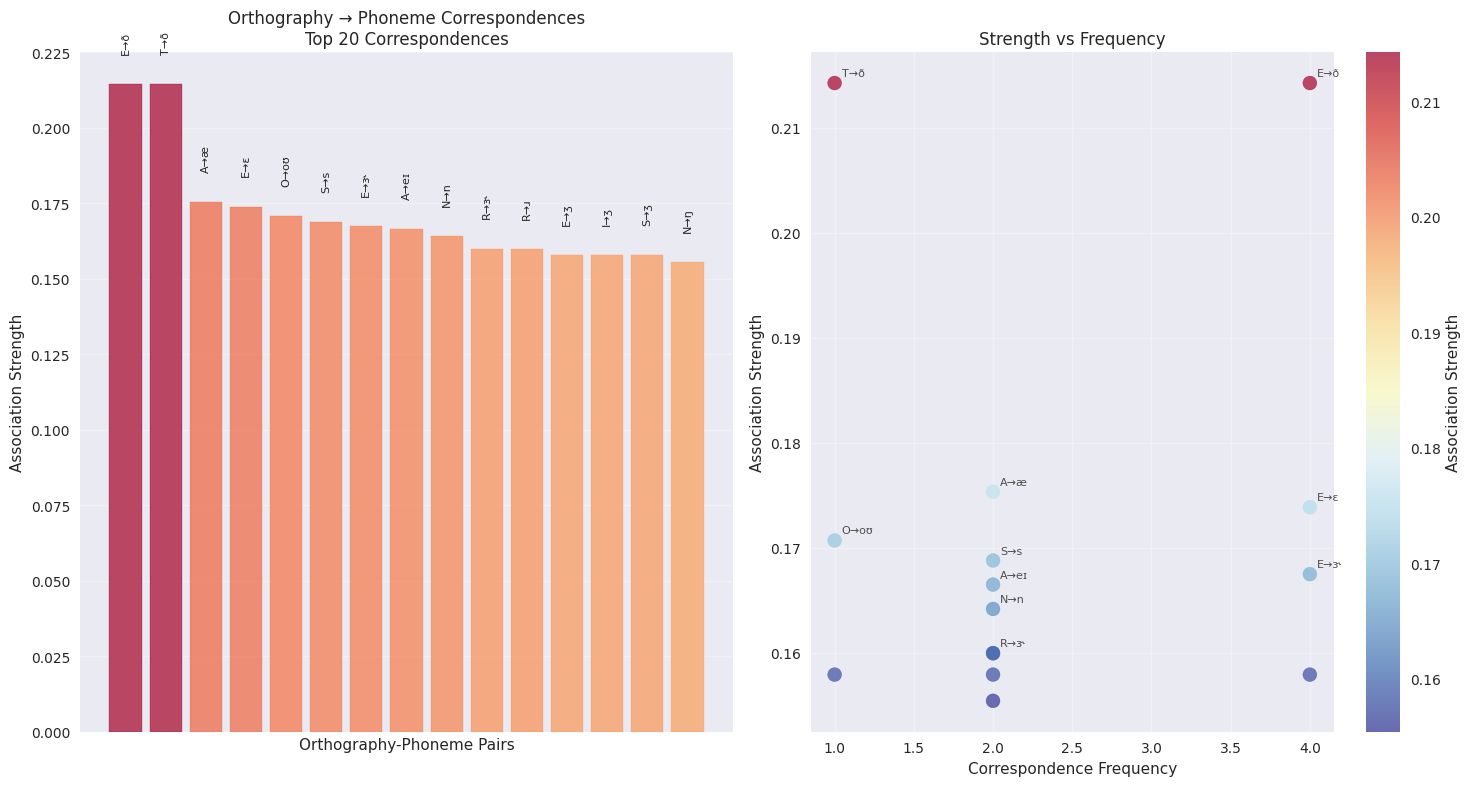

In [8]:
# Visualize orthography-phoneme relationships
def plot_correspondence_strength(ortho_phon_pairs, title):
    """Plot correspondence strength visualization."""
    
    # Extract data for plotting
    letters = [pair[0] for pair in ortho_phon_pairs[:20]]
    phonemes = [pair[1] for pair in ortho_phon_pairs[:20]]
    scores = [pair[2] for pair in ortho_phon_pairs[:20]]
    
    # Create correspondence plot
    plt.figure(figsize=(15, 8))
    
    # Bar plot of correspondence strengths
    plt.subplot(1, 2, 1)
    bars = plt.bar(range(len(scores)), scores, alpha=0.7)
    plt.xlabel('Orthography-Phoneme Pairs')
    plt.ylabel('Association Strength')
    plt.title(f'{title}\nTop 20 Correspondences')
    
    # Color bars by strength
    colors = plt.cm.RdYlBu_r([score/max(scores) for score in scores])
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add correspondence labels
    for i, (letter, phoneme) in enumerate(zip(letters, phonemes)):
        plt.text(i, scores[i] + 0.01, f"{letter}→{phoneme}", 
                rotation=90, ha='center', va='bottom', fontsize=8)
    
    plt.xticks([])
    plt.grid(True, alpha=0.3)
    
    # Scatter plot: correspondence strength vs frequency
    plt.subplot(1, 2, 2)
    
    # Calculate approximate frequencies (dummy data for illustration)
    freqs = [len([p for p in ortho_phon_pairs if p[0] == letter]) for letter in letters]
    
    plt.scatter(freqs, scores, alpha=0.7, s=100, c=scores, cmap='RdYlBu_r')
    plt.xlabel('Correspondence Frequency')
    plt.ylabel('Association Strength')
    plt.title('Strength vs Frequency')
    
    # Add labels for interesting points
    for i, (letter, phoneme, score) in enumerate(ortho_phon_pairs[:10]):
        if i < len(freqs):
            plt.annotate(f'{letter}→{phoneme}', 
                        (freqs[i], score), 
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
    
    plt.colorbar(label='Association Strength')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot correspondences
plot_correspondence_strength(ortho_phon_mle, 'Orthography → Phoneme Correspondences')

### Linguistic Insights

The CMU dictionary analysis reveals:

1. **Regular Correspondences**: Letters like 'b' → /b/ show high predictability
2. **Irregular Mappings**: Letters like 'c' map to multiple phonemes (/k/, /s/)
3. **Asymmetric Prediction**: Orthography often predicts phonetics better than vice versa
4. **Smoothing Effects**: Laplace smoothing provides more robust estimates for rare correspondences

## Classification Analysis: Mushroom Edibility

The mushroom dataset demonstrates **classification analysis** where we examine how morphological features predict edibility.

In [9]:
# Load mushroom data
mushroom_data = asymcat.read_sequences("../resources/mushrooms.tsv")
mushroom_cooccs = asymcat.collect_cooccs(mushroom_data)

print(f"Mushroom Dataset: {len(mushroom_data)} samples")
print(f"Feature-class co-occurrences: {len(mushroom_cooccs)}")

# Show sample data structure
print("\nSample data:")
for i in range(5):
    features, class_label = mushroom_data[i]
    print(f"Features: {features[:3]}..., Class: {class_label}")

# Create scorer
mushroom_scorer = asymcat.scorer.CatScorer(mushroom_cooccs)

# Compute multiple measures for classification analysis
mushroom_measures = {
    'MLE': mushroom_scorer.mle(),
    'Chi2': mushroom_scorer.chi2(),
    'Cramers_V': mushroom_scorer.cramers_v(),
    'Theil_U': mushroom_scorer.theil_u(),
    'Tresoldi': mushroom_scorer.tresoldi()
}

Mushroom Dataset: 1000 samples
Feature-class co-occurrences: 22000

Sample data:
Features: ['cap-shape:convex', 'cap-surface:smooth', 'cap-color:brown']..., Class: ['poisonous']
Features: ['cap-shape:convex', 'cap-surface:smooth', 'cap-color:yellow']..., Class: ['edible']
Features: ['cap-shape:bell', 'cap-surface:smooth', 'cap-color:white']..., Class: ['edible']
Features: ['cap-shape:convex', 'cap-surface:scaly', 'cap-color:white']..., Class: ['poisonous']
Features: ['cap-shape:convex', 'cap-surface:smooth', 'cap-color:gray']..., Class: ['edible']


In [10]:
# Analyze predictive features for edibility
def analyze_classification_features(scores, class_labels=['edible', 'poisonous']):
    """Analyze which features best predict class labels."""
    
    feature_predictions = {}
    
    for (feature, class_label), (feat_to_class, class_to_feat) in scores.items():
        if class_label in class_labels:
            if feature not in feature_predictions:
                feature_predictions[feature] = {}
            feature_predictions[feature][class_label] = {
                'feature_to_class': feat_to_class,
                'class_to_feature': class_to_feat
            }
    
    return feature_predictions

# Analyze predictive power of features
mle_features = analyze_classification_features(mushroom_measures['MLE'])

# Find best predictive features
print("\n=== Feature Predictive Power for Mushroom Edibility ===")
print("\nFeatures that strongly predict EDIBLE:")
edible_predictors = []
for feature, classes in mle_features.items():
    if 'edible' in classes:
        pred_strength = classes['edible']['feature_to_class']
        edible_predictors.append((feature, pred_strength))

edible_predictors.sort(key=lambda x: x[1], reverse=True)
for i, (feature, strength) in enumerate(edible_predictors[:10]):
    print(f"  {i+1:2d}. {feature}: P(edible|{feature}) = {strength:.3f}")

print("\nFeatures that strongly predict POISONOUS:")
poison_predictors = []
for feature, classes in mle_features.items():
    if 'poisonous' in classes:
        pred_strength = classes['poisonous']['feature_to_class']
        poison_predictors.append((feature, pred_strength))

poison_predictors.sort(key=lambda x: x[1], reverse=True)
for i, (feature, strength) in enumerate(poison_predictors[:10]):
    print(f"  {i+1:2d}. {feature}: P(poisonous|{feature}) = {strength:.3f}")


=== Feature Predictive Power for Mushroom Edibility ===

Features that strongly predict EDIBLE:
   1. gill-attachment:f: P(edible|gill-attachment:f) = 0.045
   2. ring-number:o: P(edible|ring-number:o) = 0.045
   3. veil-color:w: P(edible|veil-color:w) = 0.045
   4. veil-type:p: P(edible|veil-type:p) = 0.045
   5. stalk-color-below-ring:w: P(edible|stalk-color-below-ring:w) = 0.045
   6. stalk-color-above-ring:w: P(edible|stalk-color-above-ring:w) = 0.045
   7. stalk-surface-above-ring:s: P(edible|stalk-surface-above-ring:s) = 0.042
   8. ring-type:p: P(edible|ring-type:p) = 0.039
   9. gill-size:b: P(edible|gill-size:b) = 0.037
  10. gill-spacing:c: P(edible|gill-spacing:c) = 0.035

Features that strongly predict POISONOUS:
   1. bruises:bruises: P(poisonous|bruises:bruises) = 0.045
   2. gill-attachment:f: P(poisonous|gill-attachment:f) = 0.045
   3. gill-size:n: P(poisonous|gill-size:n) = 0.045
   4. gill-spacing:c: P(poisonous|gill-spacing:c) = 0.045
   5. odor:pungent: P(poisonou

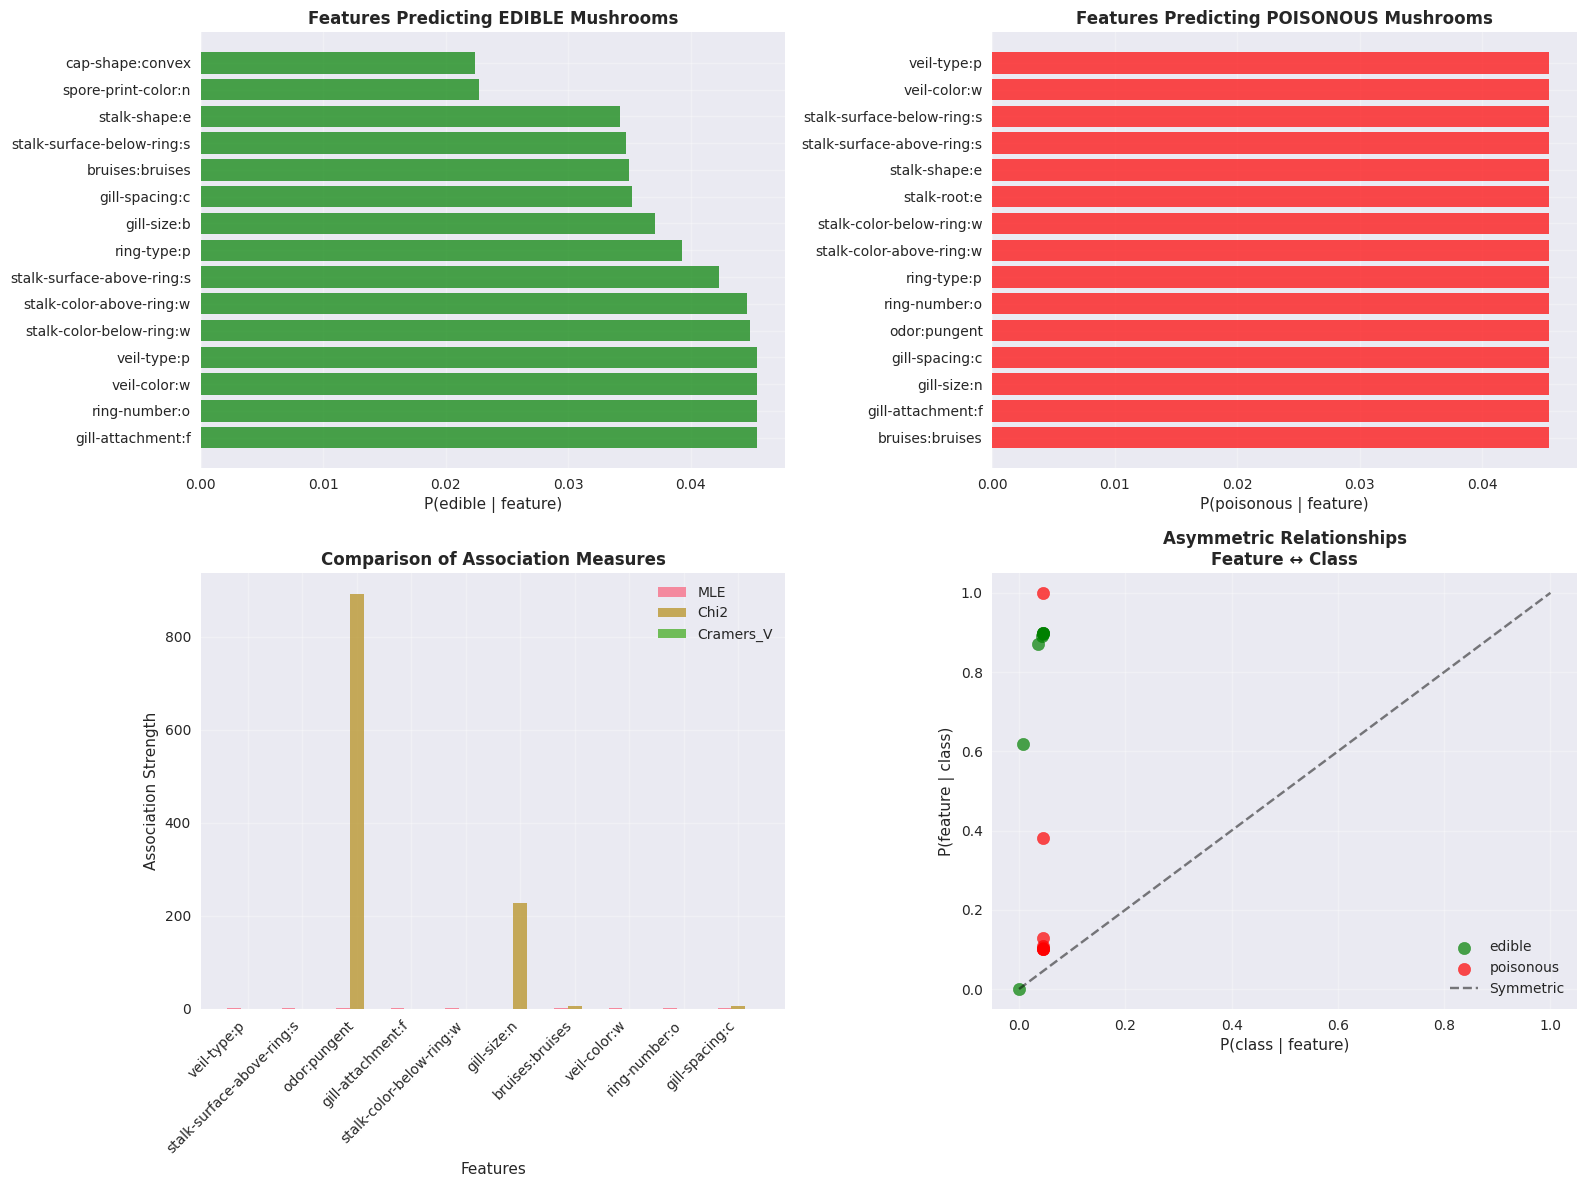

In [11]:
# Visualize classification relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature importance for edibility prediction
top_edible = edible_predictors[:15]
features_e = [f[0] for f in top_edible]
strengths_e = [f[1] for f in top_edible]

axes[0,0].barh(features_e, strengths_e, alpha=0.7, color='green')
axes[0,0].set_xlabel('P(edible | feature)')
axes[0,0].set_title('Features Predicting EDIBLE Mushrooms', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# 2. Feature importance for toxicity prediction
top_poison = poison_predictors[:15]
features_p = [f[0] for f in top_poison]
strengths_p = [f[1] for f in top_poison]

axes[0,1].barh(features_p, strengths_p, alpha=0.7, color='red')
axes[0,1].set_xlabel('P(poisonous | feature)')
axes[0,1].set_title('Features Predicting POISONOUS Mushrooms', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# 3. Comparison of multiple measures for top features
top_features_both = set([f[0] for f in top_edible[:8]] + [f[0] for f in top_poison[:8]])
measure_comparison = {}

for measure_name, scores in mushroom_measures.items():
    if measure_name in ['MLE', 'Chi2', 'Cramers_V']:
        measure_scores = []
        for feature in list(top_features_both)[:10]:
            # Find max score for this feature across all classes
            max_score = 0
            for pair, (xy, yx) in scores.items():
                if pair[0] == feature:
                    max_score = max(max_score, xy, yx)
            measure_scores.append(max_score)
        measure_comparison[measure_name] = measure_scores

# Plot measure comparison
x = np.arange(len(list(top_features_both)[:10]))
width = 0.25
feature_names = list(top_features_both)[:10]

for i, (measure, scores) in enumerate(measure_comparison.items()):
    axes[1,0].bar(x + i*width, scores, width, label=measure, alpha=0.8)

axes[1,0].set_xlabel('Features')
axes[1,0].set_ylabel('Association Strength')
axes[1,0].set_title('Comparison of Association Measures', fontweight='bold')
axes[1,0].set_xticks(x + width)
axes[1,0].set_xticklabels(feature_names, rotation=45, ha='right')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Asymmetric analysis: Feature→Class vs Class→Feature
asymmetric_data = []
for feature in list(top_features_both)[:8]:
    for class_label in ['edible', 'poisonous']:
        pair = (feature, class_label)
        if pair in mushroom_measures['MLE']:
            feat_to_class, class_to_feat = mushroom_measures['MLE'][pair]
            asymmetric_data.append({
                'feature': feature,
                'class': class_label,
                'feature_to_class': feat_to_class,
                'class_to_feature': class_to_feat
            })

if asymmetric_data:
    df_asym = pd.DataFrame(asymmetric_data)
    
    # Scatter plot of asymmetric relationships
    colors = {'edible': 'green', 'poisonous': 'red'}
    for class_label in ['edible', 'poisonous']:
        subset = df_asym[df_asym['class'] == class_label]
        axes[1,1].scatter(subset['feature_to_class'], subset['class_to_feature'], 
                         c=colors[class_label], label=class_label, alpha=0.7, s=80)
    
    # Add diagonal line for symmetry reference
    max_val = max(df_asym['feature_to_class'].max(), df_asym['class_to_feature'].max())
    axes[1,1].plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Symmetric')
    
    axes[1,1].set_xlabel('P(class | feature)')
    axes[1,1].set_ylabel('P(feature | class)')
    axes[1,1].set_title('Asymmetric Relationships\nFeature ↔ Class', fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Classification Insights

The mushroom analysis demonstrates:

1. **Strong Predictors**: Certain features are highly diagnostic of edibility/toxicity
2. **Asymmetric Prediction**: Features predict class better than class predicts features
3. **Multiple Measures**: Different association measures highlight different aspects
4. **Safety Implications**: High-confidence predictors are crucial for safety

## Advanced: Smoothing Effects

Demonstrate the mathematical and practical effects of different smoothing methods.

In [12]:
# Create a dataset with sparse co-occurrences to demonstrate smoothing
sparse_data = [
    ('common', 'frequent'), ('common', 'frequent'), ('common', 'frequent'),
    ('common', 'rare'), 
    ('rare_feature', 'frequent'),
    ('rare_feature', 'very_rare'),
]

# Fixed: sparse_data is already co-occurrences, pass directly to CatScorer

# Create scorers with different smoothing methods
scorers = {
    'MLE (No Smoothing)': asymcat.scorer.CatScorer(sparse_data, smoothing_method='mle'),
    'Laplace Smoothing': asymcat.scorer.CatScorer(sparse_data, smoothing_method='laplace'),
    'Lidstone (α=0.1)': asymcat.scorer.CatScorer(sparse_data, smoothing_method='lidstone', smoothing_alpha=0.1),
    'Lidstone (α=1.0)': asymcat.scorer.CatScorer(sparse_data, smoothing_method='lidstone', smoothing_alpha=1.0),
}

# Compute MLE scores for each method
smoothing_results = {}
for method, scorer in scorers.items():
    smoothing_results[method] = scorer.mle()

print("=== Smoothing Effects Analysis ===")
print("Sparse dataset with rare co-occurrences:")
for i, (x, y) in enumerate(sparse_data):
    print(f"  {i+1}. ({x}, {y})")

print("\nSmoothing Effects Comparison:")
print("Pair\t\t\t\tMLE\t\tLaplace\t\tLidstone(0.1)\tLidstone(1.0)")
print("="*80)

all_pairs = list(smoothing_results['MLE (No Smoothing)'].keys())
for pair in all_pairs[:8]:  # Show first 8 pairs
    row = f"{str(pair):30s}"
    for method in scorers.keys():
        xy, yx = smoothing_results[method][pair]
        row += f"\t{xy:.3f}"
    print(row)

=== Smoothing Effects Analysis ===
Sparse dataset with rare co-occurrences:
  1. (common, frequent)
  2. (common, frequent)
  3. (common, frequent)
  4. (common, rare)
  5. (rare_feature, frequent)
  6. (rare_feature, very_rare)

Smoothing Effects Comparison:
Pair				MLE		Laplace		Lidstone(0.1)	Lidstone(1.0)
('common', 'frequent')        	0.750	0.667	0.738	0.667
('common', 'rare')            	1.000	0.667	0.917	0.667
('common', 'very_rare')       	0.000	0.333	0.083	0.333
('rare_feature', 'frequent')  	0.250	0.333	0.262	0.333
('rare_feature', 'rare')      	0.000	0.333	0.083	0.333
('rare_feature', 'very_rare') 	1.000	0.667	0.917	0.667


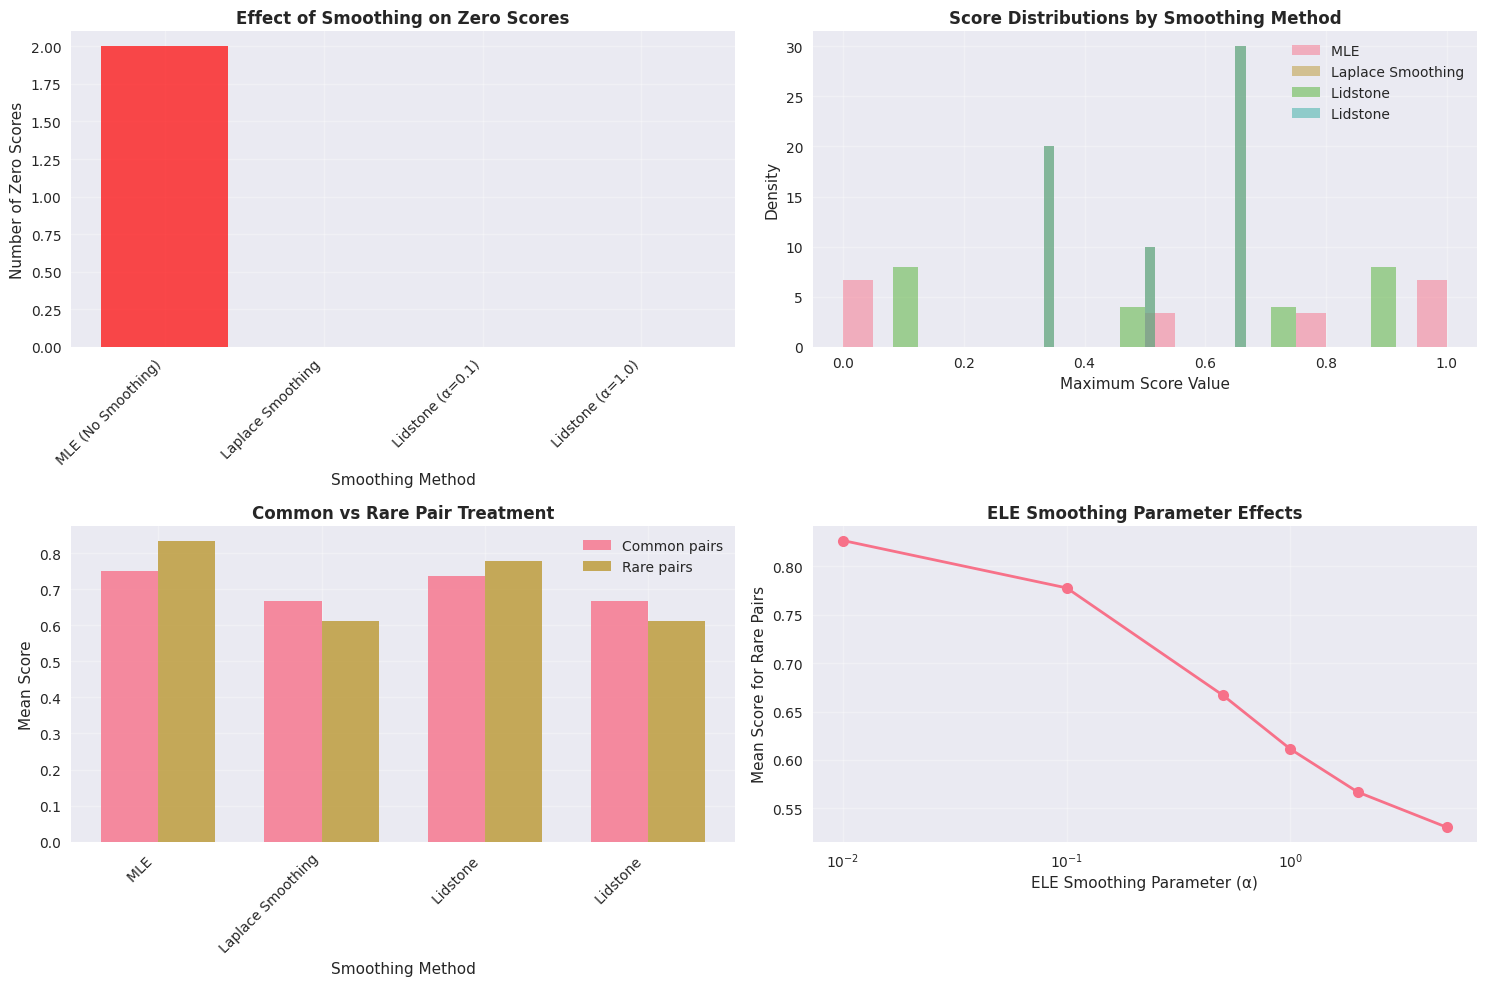

In [13]:
# Visualize smoothing effects
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Zero vs Non-zero co-occurrences
methods = list(smoothing_results.keys())
zero_counts = []
nonzero_means = []

for method in methods:
    scores = [max(xy, yx) for xy, yx in smoothing_results[method].values()]
    zero_count = sum(1 for s in scores if s == 0.0)
    nonzero_scores = [s for s in scores if s > 0.0]
    
    zero_counts.append(zero_count)
    nonzero_means.append(np.mean(nonzero_scores) if nonzero_scores else 0)

x = np.arange(len(methods))
axes[0,0].bar(x, zero_counts, alpha=0.7, color='red', label='Zero scores')
axes[0,0].set_xlabel('Smoothing Method')
axes[0,0].set_ylabel('Number of Zero Scores')
axes[0,0].set_title('Effect of Smoothing on Zero Scores', fontweight='bold')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(methods, rotation=45, ha='right')
axes[0,0].grid(True, alpha=0.3)

# 2. Score distributions
for i, method in enumerate(methods):
    scores = [max(xy, yx) for xy, yx in smoothing_results[method].values()]
    axes[0,1].hist(scores, alpha=0.5, bins=20, label=method.split('(')[0], density=True)

axes[0,1].set_xlabel('Maximum Score Value')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Score Distributions by Smoothing Method', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Rare vs Common pair treatment
# Identify rare and common pairs
pair_frequencies = {}
for x, y in sparse_data:
    pair = (x, y)
    pair_frequencies[pair] = pair_frequencies.get(pair, 0) + 1

common_pairs = [p for p, freq in pair_frequencies.items() if freq > 1]
rare_pairs = [p for p, freq in pair_frequencies.items() if freq == 1]

common_scores = {method: [] for method in methods}
rare_scores = {method: [] for method in methods}

for method in methods:
    for pair in common_pairs:
        if pair in smoothing_results[method]:
            xy, yx = smoothing_results[method][pair]
            common_scores[method].append(max(xy, yx))
    
    for pair in rare_pairs:
        if pair in smoothing_results[method]:
            xy, yx = smoothing_results[method][pair]
            rare_scores[method].append(max(xy, yx))

# Plot comparison
x = np.arange(len(methods))
width = 0.35

common_means = [np.mean(common_scores[method]) if common_scores[method] else 0 for method in methods]
rare_means = [np.mean(rare_scores[method]) if rare_scores[method] else 0 for method in methods]

axes[1,0].bar(x - width/2, common_means, width, label='Common pairs', alpha=0.8)
axes[1,0].bar(x + width/2, rare_means, width, label='Rare pairs', alpha=0.8)
axes[1,0].set_xlabel('Smoothing Method')
axes[1,0].set_ylabel('Mean Score')
axes[1,0].set_title('Common vs Rare Pair Treatment', fontweight='bold')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels([m.split('(')[0] for m in methods], rotation=45, ha='right')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Smoothing parameter effects (ELE)
alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
alpha_effects = []

for alpha in alpha_values:
    ele_scorer = asymcat.scorer.CatScorer(sparse_data, smoothing_method='lidstone', smoothing_alpha=alpha)
    ele_scores = ele_scorer.mle()
    
    # Calculate mean score for rare pairs
    rare_pair_scores = []
    for pair in rare_pairs:
        if pair in ele_scores:
            xy, yx = ele_scores[pair]
            rare_pair_scores.append(max(xy, yx))
    
    alpha_effects.append(np.mean(rare_pair_scores) if rare_pair_scores else 0)

axes[1,1].plot(alpha_values, alpha_effects, 'o-', linewidth=2, markersize=8)
axes[1,1].set_xlabel('ELE Smoothing Parameter (α)')
axes[1,1].set_ylabel('Mean Score for Rare Pairs')
axes[1,1].set_title('ELE Smoothing Parameter Effects', fontweight='bold')
axes[1,1].set_xscale('log')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretation Guidelines

### When to Use Each Measure

1. **MLE (Maximum Likelihood Estimation)**
   - **Use for**: Direct conditional probability estimation
   - **Interpretation**: P(Y|X) = probability of Y given X
   - **Range**: [0, 1]
   - **Asymmetric**: Yes, P(Y|X) ≠ P(X|Y)

2. **PMI (Pointwise Mutual Information)**
   - **Use for**: Information-theoretic association
   - **Interpretation**: How much more likely joint occurrence vs independence
   - **Range**: (-∞, +∞), 0 = independence
   - **Symmetric**: Yes, PMI(X,Y) = PMI(Y,X)

3. **Theil's U (Uncertainty Coefficient)**
   - **Use for**: Uncertainty reduction measurement
   - **Interpretation**: Proportion of uncertainty in Y reduced by knowing X
   - **Range**: [0, 1], 1 = perfect prediction
   - **Asymmetric**: Yes, U(Y|X) ≠ U(X|Y)

4. **Chi-square (χ²)**
   - **Use for**: Independence testing
   - **Interpretation**: Deviation from expected under independence
   - **Range**: [0, +∞), 0 = independence
   - **Symmetric**: Yes

5. **Jaccard Index**
   - **Use for**: Context overlap similarity
   - **Interpretation**: Proportion of shared contexts
   - **Range**: [0, 1], 1 = identical contexts
   - **Symmetric**: Yes

### Smoothing Guidelines

- **No smoothing (MLE)**: Use with abundant data, when zero probabilities are acceptable
- **Laplace smoothing**: General-purpose, adds pseudo-count of 1 to all events
- **ELE smoothing**: More sophisticated, uses prior knowledge about event probabilities
- **Parameter tuning**: Lower α values (0.1-0.5) for conservative smoothing, higher values (1.0+) for aggressive smoothing

### Practical Recommendations

1. **Start with MLE** for interpretability
2. **Add smoothing** if you have sparse data or zero co-occurrences
3. **Compare multiple measures** to get different perspectives
4. **Visualize results** to understand patterns
5. **Consider domain knowledge** when interpreting asymmetric relationships